In [1]:
from __future__ import annotations
from typing import List, Dict, Union, Optional, Tuple

In [2]:
import itertools

In [3]:
import qiskit as qk
import qiskit.quantum_info as qi
import qiskit.circuit as qc
from qiskit.providers import aer

In [4]:
from math import pi, log2, log10, cos, sin
from random import random

In [5]:
import numpy as np

In [6]:
from ray.util.multiprocessing import Pool
import ray
try:
    if False:
        class FakePool:
            def map(self, *args, **kwargs):
                return list(map(*args, **kwargs))

        pool = FakePool()
    else:
        pool
except NameError:
    ray.shutdown()
    ray.init(num_cpus=48)
    pool = Pool()

2020-04-29 18:00:30,519	INFO resource_spec.py:212 -- Starting Ray with 284.18 GiB memory available for workers and up to 125.79 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-04-29 18:00:31,522	INFO services.py:1170 -- View the Ray dashboard at localhost:8265


In [7]:
try:
    _global_rng_fix
except NameError:
    def _global_rng_fix():
        return _global_rng_fix._random_state
    _global_rng_fix._random_state = np.random.RandomState()
    np.random.RandomState = _global_rng_fix

# Utilities

## Math

In [8]:
def ilog2(x) -> int:
    return int(log2(x))
def arr_qubits(x: np.array):
    return ilog2(len(x))

In [9]:
def rand2pi() -> float:
    return random() * 2 * pi

In [10]:
rand2pi()

2.416537758795065

## Iterators

In [11]:
def pairwise(iterable):
    """
        s -> (s0,s1), (s1,s2), (s2, s3), ...
    """
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

## Parameters

In [12]:
def unique_param(prefix: str = "#") -> qc.Parameter:
    unique_param.counter += 1
    return qc.Parameter(f"{prefix}{unique_param.counter}")
unique_param.counter = 0

In [13]:
unique_param()

Parameter(#1)

In [14]:
def rand_for_param(param: qc.Parameter) -> float:
    return rand2pi()

## Postselection

In [15]:
# qiskit gates act on the rightmost qubits first!

circ1 = qc.QuantumCircuit(1)
circ1.x(0)
for c in ["00", "01", "10", "11"]:
    print(c, qi.Statevector.from_label(c).probabilities())
    print(f"X1|{c}>", qi.Statevector.from_label(c).evolve(circ1).probabilities())

00 [1. 0. 0. 0.]
X1|00> [0. 1. 0. 0.]
01 [0. 1. 0. 0.]
X1|01> [1. 0. 0. 0.]
10 [0. 0. 1. 0.]
X1|10> [0. 0. 0. 1.]
11 [0. 0. 0. 1.]
X1|11> [0. 0. 1. 0.]


In [16]:
def postselect(psi: qi.Statevector, qubit_idx: int, what: int = 0, flip_threshold: float = 1e-8) -> qi.Statevector:
    """
        postselect on a measurement outcome;
        if postselection_probability is below the threshold, we postselect on the complement
    """
    qubit_idx %= psi.num_qubits
    
    p = psi.probabilities([qubit_idx])
    
    if p[what] < flip_threshold:
        print("postselection too unlikely")
        what = 1-what
    
    proj = np.zeros(2, dtype=complex)
    proj[what] = 1 / np.sqrt(p[what])
    
    return psi.evolve(qi.Operator(np.diag(proj), input_dims=2, output_dims=2), qargs=[qubit_idx])

def postselect_multi(psi: qi.Statevector, qubit_indices: List[int], whats: List[int], flip_threshold: float = 1e-8) -> qi.Statevector:
    """
        postselect on multiple outcomes
    """
    assert len(qubit_indices) == len(whats), "indices count and targets have to be same size"
    
    for idx, what in zip(qubit_indices, whats):
        psi = postselect(psi, idx, what, flip_threshold)
        
    return psi

In [17]:
postselect(qi.Statevector.from_label("01"), 0, 1)  # indeed, index 0 refers to the right qubit!

Statevector([0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2))

## New Circuits

In [18]:
def new_circuit(width: int) -> qc.QuantumCircuit:
    circ = qc.QuantumCircuit(width)
    return circ
def empty_circuit_like(circ: qc.QuantumCircuit) -> qc.QuantumCircuit:
    return qc.QuantumCircuit(*circ.qregs, *circ.cregs)

# Variational Forms

In [19]:
from abc import ABC, abstractmethod

In [20]:
class CircuitLayer(ABC):
    # it would be nicer to derive from this base class, but cloudpickle doesn't like that at all
    
    @abstractmethod
    def specialize(self, params: np.array):
        pass
    
    @abstractmethod
    def run(self, psi: qi.Statevector) -> qi.Statevector:
        pass
    
    # not a property to avoid problems with cloudpickle
    @abstractmethod
    def num_parameters(self) -> int:
        pass
    
    @abstractmethod
    def parameters(self) -> List[qc.Parameter]:
        pass

## Unitary Layer

In [21]:
class UnitaryLayer():
    def __init__(self, width: int):
        self.circ = new_circuit(width)
        for qubit in self.circ.qubits:
            self.circ.ry(unique_param(), qubit)
            
        self.specialized = None
            
            
    def specialize(self, params: np.array) -> UnitaryLayer:
        self.specialized = self.circ.bind_parameters(dict(zip(self.parameters(), params)));
        return self
        
        
    def run(self, psi: qi.Statevector) -> qi.Statevector:
        assert self.specialized is not None, "layer has to be specialized first"
        return psi.evolve(self.specialized)
    
    
    def num_parameters(self) -> int:
        return self.circ.num_parameters
    
    
    def parameters(self) -> List[qc.Parameter]:
        # qiskit returns a set, which doesn't have a fixed order; our parameters have increasing cardinality, so can be compared
        return sorted(self.circ.parameters, key = lambda p: p.name)

In [22]:
UnitaryLayer(3).circ.draw()

┌────────┐
q_0: ┤ Ry(#2) ├
     ├────────┤
q_1: ┤ Ry(#3) ├
     ├────────┤
q_2: ┤ Ry(#4) ├
     └────────┘

In [23]:
UnitaryLayer(7).parameters()

[Parameter(#10),
 Parameter(#11),
 Parameter(#5),
 Parameter(#6),
 Parameter(#7),
 Parameter(#8),
 Parameter(#9)]

In [24]:
foo = UnitaryLayer(3).specialize(np.array([rand2pi() for _ in range(3)]))
phi = qi.Statevector.from_instruction(foo.specialized)
postselect(phi, -1, 1)

Statevector([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j, -0.80879352+0.j, -0.55726284+0.j,
              0.1547391 +0.j,  0.10661602+0.j],
            dims=(2, 2, 2))

In [25]:
phi

Statevector([-0.19957663+0.j, -0.13750931+0.j,  0.03818318+0.j,
              0.0263084 +0.j, -0.78378322+0.j, -0.54003061+0.j,
              0.1499541 +0.j,  0.10331914+0.j],
            dims=(2, 2, 2))

In [26]:
postselect_multi(phi, [-1], [1])

Statevector([ 0.        +0.j,  0.        +0.j,  0.        +0.j,
              0.        +0.j, -0.80879352+0.j, -0.55726284+0.j,
              0.1547391 +0.j,  0.10661602+0.j],
            dims=(2, 2, 2))

## Postselection Gadget Layer

This is a simple RUS circuit from arxiv.org/abs/1711.11240.
As this is a RUS circuit, the postselection can be done efficiently.

We first verify we really have the right gates.

In [27]:
def test_RyGate(angle: float) -> np.array:
    circ = qc.QuantumCircuit(1)
    circ.ry(angle, 0)

    states = [ qi.Statevector.from_label(c) for c in ["0", "1"] ]
    return np.array([[ np.dot(a.data, b.evolve(circ).data) for a in states] for b in states ])

In [28]:
test_RyGate(.2 * 2) 

array([[ 0.98006658+0.j,  0.19866933+0.j],
       [-0.19866933+0.j,  0.98006658+0.j]])

In [29]:
test_RyGate(.2 * 2)[0] == np.array([ cos(.2 ), sin(.2) ])

array([ True,  True])

In [30]:
def test_cRyGate(angle: float) -> np.array:
    circ = qc.QuantumCircuit(2)
    circ.cry(angle, 0, 1)

    states = [ qi.Statevector.from_label(c) for c in ["00", "10", "01", "11"] ]   # note qiskits reverse qubit label order for translation to torch!!
    return np.array([[ np.dot(a.data, b.evolve(circ).data) for a in states] for b in states ])

In [31]:
np.real(test_cRyGate(.2 * 2))

/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.7/site-packages/qiskit/aqua/circuits/gates/controlled_ry_gate.py:51: DeprecationWarning: The QuantumCircuit.n_qubits method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the QuantumCircuit.num_qubits method instead.
  if qubit >= self.n_qubits:
/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.7/site-packages/qiskit/aqua/circuits/gates/controlled_ry_gate.py:51: DeprecationWarning: The QuantumCircuit.n_qubits method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the QuantumCircuit.num_qubits method instead.
  if qubit >= self.n_qubits:


array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.98006658,  0.19866933],
       [ 0.        ,  0.        , -0.19866933,  0.98006658]])

In [32]:
def test_CyRzGate() -> np.array:
    circ = qc.QuantumCircuit(2)
    circ.cy(0, 1)
    circ.rz(-pi/2, 0)

    states = [ qi.Statevector.from_label(c) for c in ["00", "01", "10", "11"] ]  # note qiskits reverse qubit label order for translation to torch!!
    return np.array([[ np.dot(a.data, b.evolve(circ).data) for a in states] for b in states ])

In [33]:
u = test_CyRzGate()
np.real(u)

array([[ 1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.],
       [ 0.,  0.,  1.,  0.],
       [ 0., -1.,  0.,  0.]])

In [34]:
np.allclose(np.imag(u), 0.)

True

This means there is a factor of two we have to take into account.

In [35]:
class QuantumNeuronLayer():
    ANCILLA_NAME = "q_{ps}"
    
    def __init__(self, order: int, workspace: qc.QuantumRegister, outlane: int):
        assert 1 <= order, "order has to be positive"
        assert 0 <= outlane and outlane < workspace.size, "outlane has to be an index on the workspace register"
        
        self.order = order
        self.workspace = workspace
        self.outlane = outlane
        self.ancillas = ancillas = qc.QuantumRegister(order, name=self.ANCILLA_NAME)
        
        # parametrized circuit
        circ = qc.QuantumCircuit(workspace, ancillas)
        circ_t = empty_circuit_like(circ)
        self.params = params = [ unique_param() for _ in range(workspace.size) ]

        for i, lane in enumerate(workspace[:]):  # linear w_i * x_i
            if i == outlane: continue
            idx = i if i < outlane else i-1
            circ.cry(params[idx], lane, ancillas[0])
        circ.ry(params[-1], ancillas[0])  # bias b
            
        self.circ_param = circ
        self.circ_specialized = None
        
        # static controlled y circuits at different recursion level
        static_lanes = [ *ancillas[:], workspace[outlane] ]
        self.circ_static = [
            ( circ, circ.inverse() ) for circ in [
                self._cy_rz(empty_circuit_like(circ), static_lanes[i], static_lanes[i+1]) for i in range(0, order)
            ]
        ]
        
        
    def num_parameters(self) -> int:
        return len(self.params)
    
    
    def parameters(self) -> List[qc.Parameter]:
        return self.params
        
        
    @staticmethod
    def _cy_rz(circ: qc.QuantumCircuit, a: qc.Qubit, b: qc.Qubit) -> qc.QuantumCircuit:
        circ.cy(a, b)
        circ.rz(-pi/2, a)
        return circ
        
        
    def run_recursive(self, psi: qi.Statevector, recidx: int, dagger: bool) -> qi.Statevector:
        if recidx == 0:
            psi = psi.evolve(self.circ_specialized[False])
            psi = psi.evolve(self.circ_static[0][dagger])
            psi = psi.evolve(self.circ_specialized[True])
        
        else:
            psi = self.run_recursive(psi, recidx-1, dagger=False)
            psi = psi.evolve(self.circ_static[recidx][dagger])
            psi = self.run_recursive(psi, recidx-1, dagger=True)
            
        # postselect measurement outcome 0 on corresponding ancilla
        ancilla_to_postselect_on = len(self.workspace) + recidx
        return postselect(psi, ancilla_to_postselect_on, 0)
            
        
    def run(self, psi: qi.Statevector) -> qi.Statevector:
        assert self.circ_specialized is not None, "circuit has to be specialized first"
        return self.run_recursive(psi, self.order-1, dagger=False)
        
        
    def compatible_state(self) -> qi.Statevector:
        return qi.Statevector.from_label("0" * self.circ_param.num_qubits)
    
    
    def specialize(self, params: np.array) -> QuantumNeuron:
        lut = dict(zip(self.params, params))
        ca = self.circ_param.bind_parameters(lut)
        self.circ_specialized = ( ca, ca.inverse() )
        return self
        

In [36]:
qi.Statevector.from_label("++00").dims()

(2, 2, 2, 2)

In [37]:
# debug for torch
def print_torch(psi: qi.Statevector):
    n = len(psi.dims())
    swapc = new_circuit(n)
    for i in range(n//2):
        swapc.swap(i, n-i-1)
        
    print(psi.evolve(swapc).probabilities())


In [38]:
psi = QuantumNeuronLayer(2, qc.QuantumRegister(2), outlane=0).specialize([pi/4, pi/8]).run(qi.Statevector.from_label("-+01"))
print_torch(psi)

[4.58307934e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 9.99541692e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]


In [39]:
# consistency with qiskit

psi = qi.Statevector.from_label("0++")
print_torch(psi)

circ1 = new_circuit(4)
circ1.cry(pi/4, 1, 2)
circ2 = new_circuit(4)
circ2.ry(pi/8, 2)
circ3 = new_circuit(4)
circ3.cy(2, 0)
circ3.rz(-pi/2, 2)
circ4 = new_circuit(4)
circ4.ry(-pi/8, 2)
circ5 = new_circuit(4)
circ5.cry(-pi/4, 1, 2)

for circ in [circ1, circ2, circ3, circ4, circ5]:
    #print(circ)
    psi = psi.evolve(circ)
    print_torch(psi)

psi = postselect(psi, 2, 0)
print_torch(psi)

[0.25 0.   0.25 0.   0.25 0.   0.25 0.  ]
[0.25       0.         0.21338835 0.03661165 0.25       0.
 0.21338835 0.03661165]
[0.24048494 0.00951506 0.17283543 0.07716457 0.24048494 0.00951506
 0.17283543 0.07716457]
[0.24048494 0.00951506 0.17283543 0.07716457 0.24048494 0.00951506
 0.17283543 0.07716457]
[2.13388348e-01 3.66116524e-02 1.25000000e-01 1.25000000e-01
 2.50000000e-01 3.43179274e-35 2.13388348e-01 3.66116524e-02]
[2.13388348e-01 3.66116524e-02 3.66116524e-02 2.13388348e-01
 2.50000000e-01 3.43179274e-35 2.50000000e-01 3.92612533e-34]
[0.2845178  0.         0.04881554 0.         0.33333333 0.
 0.33333333 0.        ]


/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.7/site-packages/qiskit/aqua/circuits/gates/controlled_ry_gate.py:51: DeprecationWarning: The QuantumCircuit.n_qubits method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the QuantumCircuit.num_qubits method instead.
  if qubit >= self.n_qubits:
/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.7/site-packages/qiskit/aqua/circuits/gates/controlled_ry_gate.py:51: DeprecationWarning: The QuantumCircuit.n_qubits method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should use the QuantumCircuit.num_qubits method instead.
  if qubit >= self.n_qubits:
/home/jkrb2/opt/anaconda3/envs/rvqe/lib/python3.7/site-packages/qiskit/aqua/circuits/gates/controlled_ry_gate.py:51: DeprecationWarning: The QuantumCircuit.n_qubits method is deprecated as of 0.13.0, and will be removed no earlier than 3 months after that release date. You should

In [40]:
nl = QuantumNeuronLayer(2, qc.QuantumRegister(2), 0).specialize([.51, 2.2])
psi = qi.Statevector.from_label("0000")
psi = UnitaryLayer(2).specialize([2., 7.]).run(psi)
print(psi.probabilities())
nl.run(psi).probabilities()

[0.25600534 0.62094578 0.03592124 0.08712764 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.        ]


array([0.49999714, 0.27463746, 0.15910156, 0.06626383, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        ])

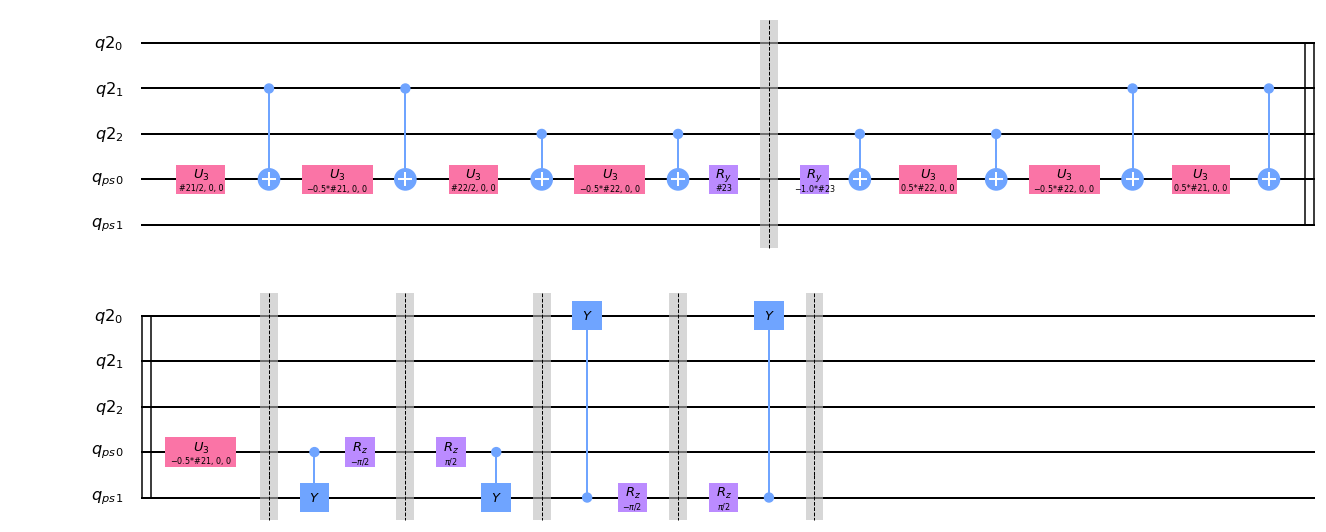

In [41]:
neuron = QuantumNeuronLayer(2, qc.QuantumRegister(3), 0)
c = neuron.circ_param
foo = empty_circuit_like(c)
foo += c
foo.barrier()
foo += c.inverse()
foo.barrier()
for c, ct in neuron.circ_static:
    foo += c
    foo.barrier()
    foo += ct
    foo.barrier()
foo.draw(output="mpl")

## Output Layer

In the actual algorithm, we would run a number of rnn's in parallel, sampling from the distributions to estimate them. Note that we still evolve forward by

In [42]:
OUT_CREG_NAME = "c_{out}"
def output_layer(width: int, outcount: int) -> qc.QuantumCircuit:
    """
        Measure the first outcount lanes
    """
    circ = qc.QuantumCircuit(width)
    circ.add_register(qc.ClassicalRegister(outcount, OUT_CREG_NAME))
    circ.measure(circ.qubits[:outcount], circ.clbits[:outcount])
    
    return circ

In [43]:
output_layer(5, 3).draw()

┌─┐      
      q_0: ┤M├──────
           └╥┘┌─┐   
      q_1: ─╫─┤M├───
            ║ └╥┘┌─┐
      q_2: ─╫──╫─┤M├
            ║  ║ └╥┘
      q_3: ─╫──╫──╫─
            ║  ║  ║ 
      q_4: ─╫──╫──╫─
            ║  ║  ║ 
c_{out}_0: ═╩══╬══╬═
               ║  ║ 
c_{out}_1: ════╩══╬═
                  ║ 
c_{out}_2: ═══════╩═

In [44]:
def out_to_list(out: str) -> List[int]:
    return [ int(c) for c in out ]

In [45]:
def measure_and_tomography(psi: qi.Statevector, out: Union[int, List[int]]) -> Tuple[str, qi.Statevector, np.ndarray]:
    if isinstance(out, int):
        return (*psi.measure(range(out)), psi.probabilities(range(out)))
    elif isinstance(out, (list, np.ndarray)):
        return (
            "".join(str(v) for v in out),
            postselect_multi(psi, range(len(out)), out),
            psi.probabilities(range(len(out)))
        )
    else:
        raise f"wrong out type {type(out)}"

In [46]:
foo = UnitaryLayer(3).specialize([ rand2pi() for _ in range(3) ])
phi = qi.Statevector.from_instruction(foo.specialized)
phi

Statevector([-0.10348201+0.j, -0.92486559+0.j,  0.02843337+0.j,
              0.25412187+0.j, -0.02806833+0.j, -0.25085934+0.j,
              0.00771223+0.j,  0.06892768+0.j],
            dims=(2, 2, 2))

In [47]:
measure_and_tomography(phi, [1, 1, 1])

('111',
 Statevector([0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
              1.+0.j],
             dims=(2, 2, 2)),
 array([1.07085262e-02, 8.55376353e-01, 8.08456270e-04, 6.45779227e-02,
        7.87830889e-04, 6.29304072e-02, 5.94784765e-05, 4.75102563e-03]))

In [48]:
phi

Statevector([-0.10348201+0.j, -0.92486559+0.j,  0.02843337+0.j,
              0.25412187+0.j, -0.02806833+0.j, -0.25085934+0.j,
              0.00771223+0.j,  0.06892768+0.j],
            dims=(2, 2, 2))

In [49]:
measure_and_tomography(phi, 3)

('001',
 Statevector([ 0.+0.j, -1.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,  0.+0.j,
               0.+0.j],
             dims=(2, 2, 2)),
 array([1.07085262e-02, 8.55376353e-01, 8.08456270e-04, 6.45779227e-02,
        7.87830889e-04, 6.29304072e-02, 5.94784765e-05, 4.75102563e-03]))

In [50]:
phi

Statevector([-0.10348201+0.j, -0.92486559+0.j,  0.02843337+0.j,
              0.25412187+0.j, -0.02806833+0.j, -0.25085934+0.j,
              0.00771223+0.j,  0.06892768+0.j],
            dims=(2, 2, 2))

## Input Layer

We assume the inputs have been measured, i.e. are either initialized to 0 or are preceded by an output layer which measures them.

In [51]:
def input_layer(width: int, target_content: List[int], outlane_content: List[int]) -> qc.QuantumCircuit:
    """
        Reset the first #target_content lanes
    """
    circ = qc.QuantumCircuit(width)
    for i, (tar, cur) in enumerate(zip(target_content, outlane_content)):
        if tar != cur:
            circ.x(circ.qubits[i])
    return circ

In [52]:
input_layer(6, [1, 1, 0, 1], [0, 0, 0, 0]).draw()

┌───┐
q_0: ┤ X ├
     ├───┤
q_1: ┤ X ├
     └───┘
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
q_4: ─────
          
q_5: ─────

In [53]:
input_layer(6, [1, 1, 0, 1], [0, 1, 1, 1]).draw()

┌───┐
q_0: ┤ X ├
     └───┘
q_1: ─────
     ┌───┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
          
q_5: ─────

# RVQE Circuit

In [54]:
class RVQE:
    """
        Generic RVQE Model
    """
    def __init__(self, workspace_size: int, inout_size: int, num_stages: int, tanh_order: int = 2):
        assert inout_size < workspace_size, "has to be at least one wider than the data fed"
        
        self.inout_size = inout_size
        self.num_stages = num_stages
        self.tanh_order = tanh_order
        self.width = workspace_size + tanh_order
        
        self.workspace = qc.QuantumRegister(workspace_size)

        # each stage is a single qubit rotation layer, followed by a quantum neuron for each output lane
        self.layers = []
        for _ in range(num_stages):
            self.layers.append(UnitaryLayer(workspace_size))
            self.layers += [ QuantumNeuronLayer(tanh_order, self.workspace, lane) for lane in range(workspace_size) ]
        
        self.param_count = sum([ layer.num_parameters() for layer in self.layers ])       
    
        
        
    def random_initial_params(self) -> np.array:
        return np.array([
            rand_for_param(param) for layer in self.layers for param in layer.parameters()
        ])
    
    
    def initial_state(self) -> qi.Statevector:
        """
            return all zero state on width+1 qubits
        """
        return qi.Statevector.from_label("0" * self.width)
    
    
    def specialize(self, params: np.array):
        assert len(params) == self.param_count, "number of parameters has to match"
        
        idx = 0        
        
        for layer in self.layers:
            layer.specialize(params[idx : idx + layer.num_parameters()])
            idx += layer.num_parameters()
                
        return self
    
    
    def run(self, inputs: List[List[int]], postselect_measurement: bool = True) -> qi.Statevector:   
        psi = self.initial_state()  # input state
        
        output_probs = []
        outputs = []
        last_measured = [0 for _ in range(self.inout_size)]
        
        for inpt, target in pairwise(inputs):           
            # pass input in
            assert len(inpt) == self.inout_size and len(target) == self.inout_size, f"inputs have to be of size {self.inout_size}"
            psi = psi.evolve(input_layer(self.width, inpt, last_measured))
            
            # execute RVQE cell
            for layer in self.layers:
                psi = layer.run(psi)
                
            #  measure (we really postselect on measuring target)
            out, psi, probs = measure_and_tomography(psi, target if postselect_measurement else len(target))
            last_measured = out_to_list(out)
            outputs.append(out)
            output_probs.append(probs)
            
        return outputs, output_probs
    

In [55]:
rvqe = RVQE(workspace_size=6, inout_size=3, num_stages=2)
inputs = np.random.randint(2, size=(10, 3))
print(inputs)
params = [ rand2pi() for _ in range(rvqe.param_count) ]

[[1 0 0]
 [0 1 0]
 [1 1 0]
 [1 0 0]
 [1 1 0]
 [0 0 0]
 [0 1 1]
 [0 0 0]
 [0 1 0]
 [1 0 1]]


In [56]:
# rvqe.specialize(params).run(inputs, postselect_measurement=True)

In [57]:
# %time rvqe.specialize(params).run(inputs, postselect_measurement=True)

In [58]:
RVQE(workspace_size=2, inout_size=1, num_stages=1, tanh_order=1).layers

In [59]:
# consistency with torch
rvqe = RVQE(workspace_size=2, inout_size=1, num_stages=1, tanh_order=3).specialize( [2, 1, 2, 2, 2, 2])
rvqe.run([[0], [1], [1], [0], [1]], qi.Statevector.from_label("00000"))

(['1', '1', '0', '1'],
 [array([0.39646866, 0.60353134]),
  array([0.11622709, 0.88377291]),
  array([0.10745037, 0.89254963]),
  array([0.39487697, 0.60512303])])

# Training

an invalid character is the all 1s

In [60]:
def char_to_bin6(char: str) -> List[int]:
    try:
        idx = char_to_bin6.characters.index(char[0])
    except ValueError:
        idx = 2**6-1
    return char_to_bin6.lut[idx]
    
char_to_bin6.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz0123456789 ,.!?-\"'" ]
char_to_bin6.lut = [
    [ int(c) for c in "{0:06b}".format(n) ] for n in range(2**6)
]

char_to_bin6("c")

[0, 0, 0, 0, 1, 0]

In [61]:
def char_to_bin5(char: str) -> List[int]:
    try:
        idx = char_to_bin5.characters.index(char[0])
    except ValueError:
        idx = 2**5-1
    return char_to_bin5.lut[idx]
    
char_to_bin5.characters = [ c for c in "abcdefghijklmnopqrstuvwxyz ,.!?" ]
char_to_bin5.lut = [
    [ int(c) for c in "{0:05b}".format(n) ] for n in range(2**5)
]

char_to_bin5("?")

[1, 1, 1, 1, 0]

In [62]:
def bin_to_onehot(lst: List[int], width: int) -> np.array:
    idx = int("".join(str(n) for n in lst), 2)
    ret = np.zeros(2**width)
    ret[idx] = 1.
    return ret

In [63]:
bin_to_onehot(char_to_bin5("?"), 5)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

## Training Sets

In [64]:
def constant_sentence(length: int, constant: List[int]) -> List[int]:
    return [ constant for _ in range(length) ]

In [65]:
def alternating_sentence(length: int, constants: List[List[int]]) -> List[int]:
    return [ constants[i % len(constants)] for i in range(length) ]

In [66]:
alternating_sentence(5, ["a", "b"])

['a', 'b', 'a', 'b', 'a']

## Optimize

In [67]:
from scipy.optimize import minimize

In [68]:
def crossentropy(target: np.array, predicted: np.array) -> float:
    return -sum(target[target!=0] * np.log(predicted[target!=0]))

In [69]:
crossentropy(np.array([1, 0, 0]), np.array([.9, .1, .0]))

0.10536051565782628

In [70]:
crossentropy(np.array([1, 0, 0]), np.array([.5, .25, .25]))

0.6931471805599453

In [71]:
class LRScheduler:
    def __init__(self, optimizer, patience: int = 20, threshold: float = 0.0001, loss_transf = log10):
        self.patience = patience
        self.threshold = threshold
        self.optimizer = optimizer
        self.loss_transf = loss_transf
        self.time_since_best = 0
        self.best = np.inf
        
    def step(self, loss):
        loss = self.loss_transf(loss)
        
        if loss < (self.best - self.threshold):
            self.time_since_best = 0
            self.best = loss
            
        else:
            self.time_since_best += 1
            
        if self.time_since_best > self.patience:
            self.optimizer.learning_rate *= 0.666
            self.time_since_best = 0
            print(f"reduced learning rate to {self.optimizer.learning_rate:.2e}")
            

In [72]:
class VQEOptimizer:
    def __init__(self, learning_rate: float = 1e-3, β1: float = .9, β2: float = .999, ε: float = 1e-8):
        self.ε = ε
        self.β1 = β1
        self.β2 = β2
        self.learning_rate = learning_rate
        
        self.v = 0.
        self.sqr = 0.
        
    def grad(self, f, x0) -> np.array:
        losses = np.array(pool.map(f, [
            x0,
            *[ (x0 + self.ε*x) for x in np.eye(len(x0)) ]
        ]))
        l0 = losses[0]
        l1 = losses[1:]
        return (l1 - l0) / self.ε
    
    def step(self, f, x0, t):
        """
            Adam
        """
        
        β1, β2 = self.β1, self.β2
        
        g = self.grad(f, x0)
        self.v = β1 * self.v + (1-β1) * g
        self.sqr = β2 * self.sqr + (1-β2) * (g*g)
        
        v_bias_corr = self.v / (1. - β1 ** t)
        sqr_bias_corr = self.sqr / (1. - β2 ** t)
        
        div = self.learning_rate * v_bias_corr / (np.sqrt(sqr_bias_corr) + self.ε)
        x1 = x0 - div
        
        return x1, f(x1)
    
    

In [73]:
rvqe = RVQE(workspace_size=6, inout_size=3, num_stages=3)
rvqe.param_count

126

In [74]:
from timeit import default_timer as timer

In [75]:
def run_optim(params: Optional[np.array] = None):
    EPOCHS = 5000
    SENTENCE_LENGTH = 20

    if params is None:
        params = rvqe.random_initial_params()
        
    optimizer = VQEOptimizer(learning_rate=.01)
    scheduler = LRScheduler(optimizer, patience=50)

    postselected_training_phase = True

    best_loss = np.inf
    last_best_loss = 0
    epoch = 0
    while epoch < EPOCHS:
        epoch += 1
        time_start = timer()

        sentence = alternating_sentence(SENTENCE_LENGTH,[ [0, 0, 0], [0, 0, 1], [0, 1, 0], [0, 1, 1] ])
        sentence_onehot = [ bin_to_onehot(s, len(sentence[0])) for s in sentence ]

        def f(params: np.array) -> float:
            _, probs = rvqe.specialize(params).run(sentence, postselect_measurement=postselected_training_phase)
            loss = np.mean([ crossentropy(a, b) for a, b in zip(sentence_onehot, probs) ])
            return loss

        params, loss = optimizer.step(f, params, epoch)
        scheduler.step(loss)

        # print loss each epoch
        print(f"{'PS' if postselected_training_phase else 'MS'} {epoch:04d}/{EPOCHS:04d} {timer() - time_start:5.1f}s  loss={loss:7.3e}")

        # choose between postselected and measured training phase
        if loss < .0666:
            postselected_training_phase = False
        if loss > .2:
            postselected_training_phase = True
            
        # print samples every few epochs
        if epoch % 10 == 0: 
            def f(_):
                out, _ = rvqe.specialize(params).run(sentence, postselect_measurement=False)
                return out

            for pred in pool.map(f, range(3)):
                print(f"pred={' '.join(pred)}")

In [ ]:
run_optim()

PS 0001/5000 122.5s  loss=3.261e+00
PS 0002/5000 106.2s  loss=3.058e+00
PS 0003/5000 105.6s  loss=2.855e+00
PS 0004/5000 105.6s  loss=2.682e+00
PS 0005/5000 103.8s  loss=2.514e+00
PS 0006/5000 100.5s  loss=2.355e+00
PS 0007/5000 101.0s  loss=2.209e+00
PS 0008/5000 103.5s  loss=2.077e+00
PS 0009/5000 101.9s  loss=1.963e+00
PS 0010/5000 101.4s  loss=1.863e+00
pred=110 011 111 111 100 110 001 010 111 001 110 001 110 100 100 111 111 110 111
pred=011 011 111 110 101 100 111 111 000 110 111 111 101 110 010 001 100 011 001
pred=101 110 110 110 101 011 110 111 100 001 010 101 000 100 011 110 001 110 111
PS 0011/5000  99.0s  loss=1.771e+00
PS 0012/5000 104.2s  loss=1.697e+00
PS 0013/5000 101.2s  loss=1.628e+00
PS 0014/5000 102.4s  loss=1.560e+00
PS 0015/5000 104.3s  loss=1.470e+00
PS 0016/5000 102.1s  loss=1.418e+00
PS 0017/5000 102.0s  loss=1.359e+00
PS 0018/5000 104.7s  loss=1.292e+00
PS 0019/5000 100.3s  loss=1.217e+00
PS 0020/5000 102.0s  loss=1.139e+00
pred=000 001 100 011 110 110 111 100 

## Profiling

In [ ]:
#%load_ext line_profiler

In [ ]:
#%lprun -f qi.Statevector.evolve -f qi.Statevector.__init__ -f qi.states.quantum_state.QuantumState.__init__ -f np.random.RandomState run_optim()